# <span style="color:red">  Author: Nikolin Prenga  </span>
# <span style="color:green">  Date: April 18, 2024.</span>
# <span style="color:blue">  Description: This code focuses on developing ROC curves for multiclass classification. In this script, you will find my implementation of a ROC curve from scratch, <br> as well as its extension to One-vs-One and One-vs-Many approaches</span>

#  Import the necessary libraries


In [1]:
import Extract_Data 
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from scipy.integrate import trapz
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import scipy
from sklearn import metrics
# Ignore all warnings
warnings.filterwarnings("ignore")


# In this section, we imported the predicted probabilities as 'y_pred_probabilities', 
# the true labels as 'Y_test_MRI', and the predicted labels as 'predicted_classes'. 
# This is an artificial neural network implemented on MRI images.
# For more information about the code and the model, refer to neural_network_in_python.py



In [2]:
Y_test_MRI = Extract_Data.Y_test_shuffled

from neural_network_in_python import y_pred_probabilities , predicted_classes
# Class names
class_names = {
    0: "No Tumor",
    1: "Glioma Tumor",
    2: "Meningioma Tumor",
    3: "Pituitary Tumor"
}

13/13 [==============================] - 0s 6ms/step


In [3]:
# Read the 'heart.csv' file into a pandas DataFrame and store it in the variable 'data'
data = pd.read_csv('heart.csv')

# Display the first few rows of the DataFrame to inspect the data
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


#  The "target" column indicates whether the patient has heart disease or not. 

#  Extract the target variable 
# Extract the features used for prediction.

In [4]:
y = data['target']

X = data.drop('target', axis=1, inplace=False)

In [5]:
# # Load the heart disease dataset from the CSV file.
# data = pd.read_csv('heart.csv')

# # The "target" column indicates whether the patient 
# # has heart disease or not. 

# # It is binary-valued, with 0 representing no disease and 1 
# # representing presence of disease.
# # # Extract the target variable 
# y = data['target']

# # Extract the features used for prediction.
# X = data.drop('target', axis=1, inplace=False)
# data.head()

# Splitting the dataset into training and testing sets with a test size of 20%.

In [6]:
X_train, X_test, Y_train , y_test = train_test_split(X,y, test_size=0.20)

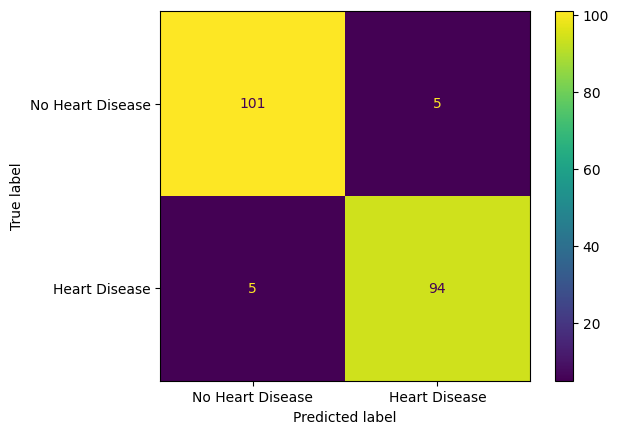

Printing Classification Report
                  precision    recall  f1-score   support

No Heart Disease       0.95      0.95      0.95       106
   Heart Disease       0.95      0.95      0.95        99

        accuracy                           0.95       205
       macro avg       0.95      0.95      0.95       205
    weighted avg       0.95      0.95      0.95       205





In [7]:
def catboost_return_Probabilities(Training_dataset, Testing_dataset, label_train , labels_testing):
    # Define target names for confusion matrix
    target_names= ['No Heart Disease', 'Heart Disease']

    # Split the training dataset further into training and validation sets
    x_train, x_val, y_train, y_val   = train_test_split(Training_dataset, label_train, test_size=0.1)
    eval_sets = [(x_val, y_val)]

    # Initialize CatBoost classifier
    model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=41)
    # Fit the model
    model.fit(x_train, y_train, eval_set = eval_sets, early_stopping_rounds=9, plot=False, use_best_model=True,
              verbose_eval=False)
    
    # Predict probabilities and labels for the testing dataset
    prob = model.predict_proba(X_test)
    pred = model.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, pred)
    displot = ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=target_names)
    displot.plot()
    plt.show()

    print('Printing Classification Report')
    print(classification_report(y_test, pred, target_names= target_names))
    print('\n')
      
    return prob, pred
probs,outcomes = catboost_return_Probabilities(X_train, X_test, Y_train , y_test)



# ROC Curve from implemented from Scratch 

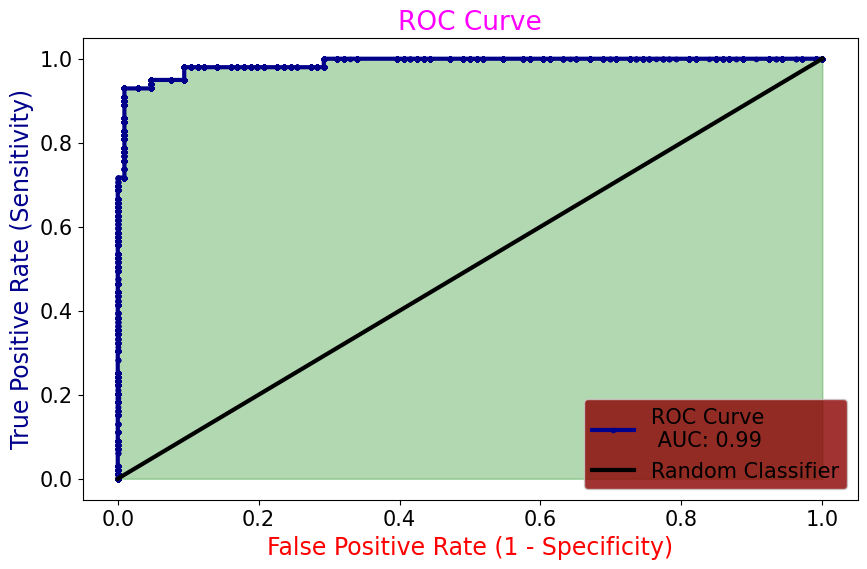

In [8]:
class Make_Roc_Curve(object):
    def __init__(self, prob, true_labels, Area=None,  n_thresholds=10000):
        self.prob=prob[:, 1]
        self.n_thresholds= n_thresholds
        self.true_labels = true_labels
        self.Area=Area

    def sort_prob(self):
        # sort the probabilities in descenting order
        sorted_indices_descenting = np.argsort(self.prob)[::-1]
        self.prob= self.prob[sorted_indices_descenting]
        self.true_labels = self.true_labels[sorted_indices_descenting]

    def compute_tpr_fpr(self):
        
        self.prob = np.array(self.prob)
        self.true_labels = np.array(self.true_labels)
        self.sort_prob()
  
        TPR_lists= np.zeros(self.n_thresholds)
        FPR_lists = np.zeros(self.n_thresholds)

        thresholds_local = np.linspace(start=0, stop=1, num= self.n_thresholds, endpoint=True)

        for index , each_threshold in enumerate(thresholds_local):
            
            predicted_labels = (self.prob >= each_threshold).astype(int)

            TP = np.sum((predicted_labels == 1) & (self.true_labels == 1))
            TN = np.sum((predicted_labels == 0) & (self.true_labels == 0))
            FP = np.sum((predicted_labels == 1) & (self.true_labels == 0))
            FN = np.sum((predicted_labels == 0) & (self.true_labels == 1))

            TPR = TP/(TP+FN)
            FPR = FP / (FP+TN)
            TPR_lists[index]= TPR
            FPR_lists[index]= FPR
        
        self.TPR_lists = TPR_lists
        self.FPR_lists = FPR_lists

    def compute_Roc_curve_Area(self):
        #area = trapz(self.TPR_list, self.FPR_lists)
        Area = 0
        for k in range(len(self.TPR_lists)-1):
            delta_y = (self.TPR_lists[k]+self.TPR_lists[k+1])/2.0
            delta_x =abs(self.FPR_lists[k+1]-self.FPR_lists[k])
            Area = Area + delta_y*delta_x
        return Area

    def Plot_Roc_Curve(self):
        self.compute_tpr_fpr()

        if self.Area:
            self.Area = self.compute_Roc_curve_Area()
            auc = np.round(self.Area, 2)
        plt.figure(figsize=(10,6))
        plt.plot(self.FPR_lists, self.TPR_lists,'.-', lw=3, color='darkblue', label=f'ROC Curve \n AUC: {auc}')
        plt.fill_between(self.FPR_lists, self.TPR_lists, color='green', alpha=0.3)
        plt.plot([0,1], [0,1], lw=3, color='black', label= f'Random Classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)', color='red', fontsize=17)
        plt.ylabel('True Positive Rate (Sensitivity)', color='darkblue', fontsize=17)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15) 

        plt.title('ROC Curve', color ='magenta', fontsize=19)
        plt.legend(fontsize=15, facecolor='darkred')
        plt.show()

Make_Roc_Curve(probs, y_test, Area=True).Plot_Roc_Curve()


# Confusion Matrix and Classification Report for Multiclass Classification from MRI Images Dataset

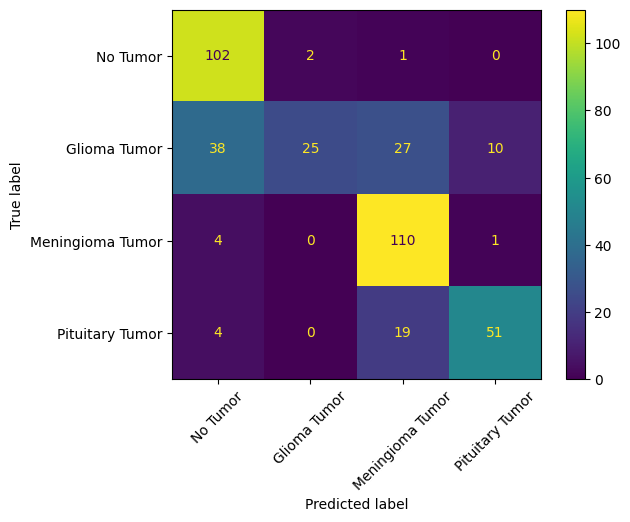



Printing Classification Report


                  precision    recall  f1-score   support

        No Tumor       0.69      0.97      0.81       105
    Glioma Tumor       0.93      0.25      0.39       100
Meningioma Tumor       0.70      0.96      0.81       115
 Pituitary Tumor       0.82      0.69      0.75        74

        accuracy                           0.73       394
       macro avg       0.78      0.72      0.69       394
    weighted avg       0.78      0.73      0.69       394



In [9]:
target_names_mri = [class_names[i] for i in range(4)]

cm_mri = confusion_matrix(Y_test_MRI, predicted_classes)
displot_mri = ConfusionMatrixDisplay(confusion_matrix=cm_mri ,display_labels=target_names_mri)
displot_mri.plot()
plt.xticks(rotation=45)
plt.show()

print('\n')

print('Printing Classification Report')
print('\n')
print(classification_report(Y_test_MRI, predicted_classes, target_names= target_names_mri))

In [10]:
## The One-vs-the-Rest (OvR) multiclass strategy, also known as one-vs-all,
## consists of computing a ROC curve for each of the n_classes. In each step, 
## a given class is considered the positive class, 
## while the remaining classes are treated as the negative class collectively.

## We want to binarize the testing dataset
## We create n_classes columns where the first class (0) corresponds to the first column,
## the second class (1) to the second column, and so on.
## We iterate over the testing dataset, and if we encounter a specific class label,
## we set the corresponding column value to 1 and the rest to 0.

In [11]:
import random 
def next_Binarize(labels):

    print('Assuming that your classes are arranged numerically from 0 to n.')
    print('If your classes are not arranged from zero to n, you must modify this code.')

    # Get unique classes from the testing dataset.
    my_classes= np.unique(labels)
    # Initialize binarized data array.

    binarize_data = np.zeros((labels.shape[0], len(my_classes)))
    # Iterate over the testing dataset.
    for iter, check_class in enumerate(labels):
        # Set the value to 1 for the corresponding class, rest to 0
        binarize_data[iter][check_class] =1
    return binarize_data

Assuming that your classes are arranged numerically from 0 to n.
If your classes are not arranged from zero to n, you must modify this code.


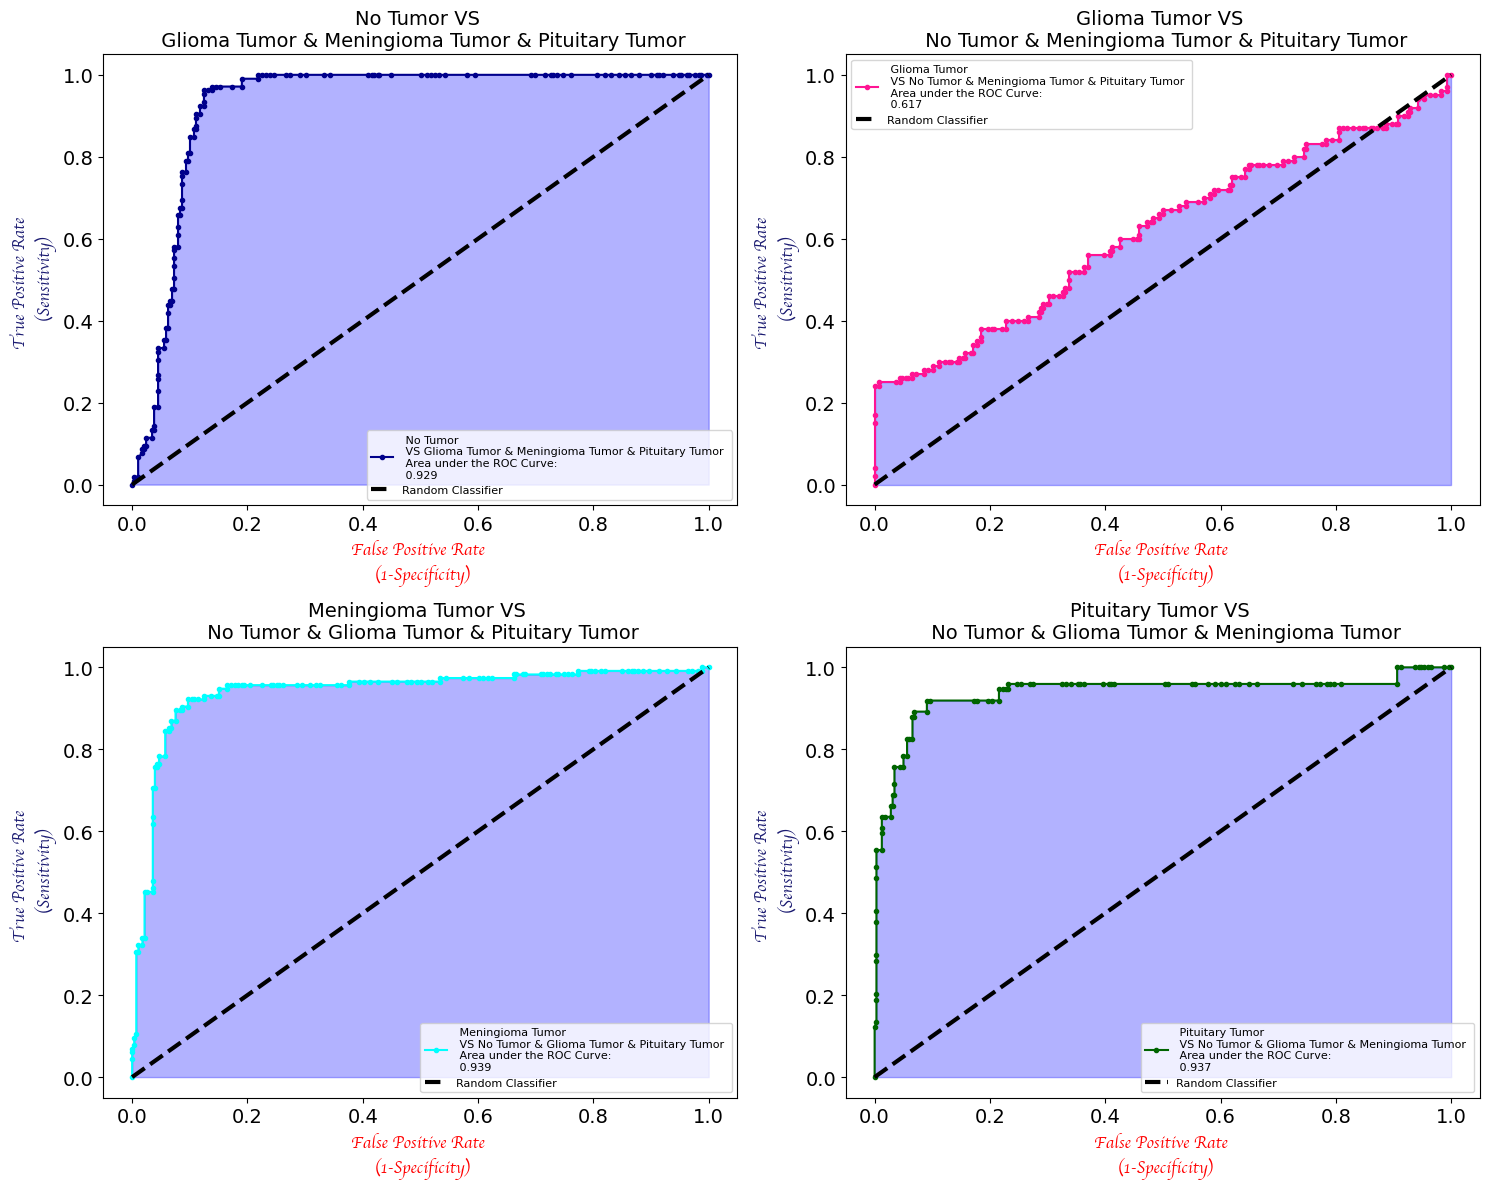


 
 The Macro Averaging of the Area under the ROC Curve is: 0.855 


In [12]:
def plot_One_vs_the_Rest(Binarized_label, n_classes, class_names):
    # Define colors for each class.
    colors = ['darkblue', 'deeppink', 'cyan',  'darkgreen']
    # Create a figure for plotting.
    plt.figure(figsize=(15, 12))
    all_accs = []
    ## Iterate over each class for plotting ROC curve.
    for clas_iter, colore in zip(range(n_classes), colors):
        # Get the current class name.
        class_consideration =class_names[clas_iter]
        
        # Get the rest of the classes' names.
        Rest = ' & '.join([class_names[i] for i in range(n_classes) if i != clas_iter])

        # Compute ROC curve for the current class. True Positive Rate Versus False Positive Rate
        fpr, tpr, thresholdsq = metrics.roc_curve(Binarized_label[: , clas_iter], y_pred_probabilities[: , clas_iter])
        # Compute AUC for the current class.
        auc = np.round(metrics.auc(fpr, tpr), 3)
        all_accs.append(auc)

        ax = plt.subplot(2, 2,  clas_iter+ 1 )

        ax.plot(fpr, tpr, '.-', 
                label =f' {class_consideration} \n VS {Rest} \n Area under the ROC Curve: \n {auc}', color =colore )
        plt.fill_between(fpr, tpr, color='blue', alpha=0.3)
        ax.plot([0, 1], [0, 1], '--', lw=3, label = 'Random Classifier', color='black')

        ####################################################################################################################
        #fpr_test, tpr_test, _ = roc_curve(y_test, probs[: , 1])
        #auc_test = np.round(metrics.auc(fpr_test, tpr_test), 3)
        #ax.plot(fpr_test, tpr_test,lw=3,  color='darkgreen', label=f'CatBoost on Heart Disease Data- Heart Disease Vs No Heart Disease \n AUC: {auc_test}')
        #plt.fill_between(fpr_test, tpr_test, color='orange', alpha=0.3)
        #plt.fill_between(self.FPR_lists_2, self.TPR_lists_2, color='orange', alpha=0.3)
        ####################################################################################################################
       
        ax.set_title(f'{class_consideration} VS \n {Rest}', size=14)
        ax.set_xlabel('False Positive Rate \n (1-Specificity)',fontname= 'cursive', fontsize=12)
        ax.set_ylabel('True Positive Rate \n (Sensitivity)', fontname= 'cursive', fontsize=12)
        ax.xaxis.label.set_color('red')
        ax.yaxis.label.set_color('midnightblue')
        #ax.set_title(f'ROC Curve for {class_consideration} \n VS {Rest}',fontname="serif", fontsize=8)
        #plt.title('ROC Curves', color ='magenta', fontsize=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()    
    print(f'\n \n The Macro Averaging of the Area under the ROC Curve is: {np.round(np.sum(all_accs)/len(all_accs), 3)} ')  
Binarized_data = next_Binarize(Y_test_MRI)   
plot_One_vs_the_Rest(Binarized_data, 4, class_names)

## Here, we are developing the ROC Curve for One-vs-One multiclass classification.


 
 The Macro Averaging of the Area under the ROC Curve is: 0.858 


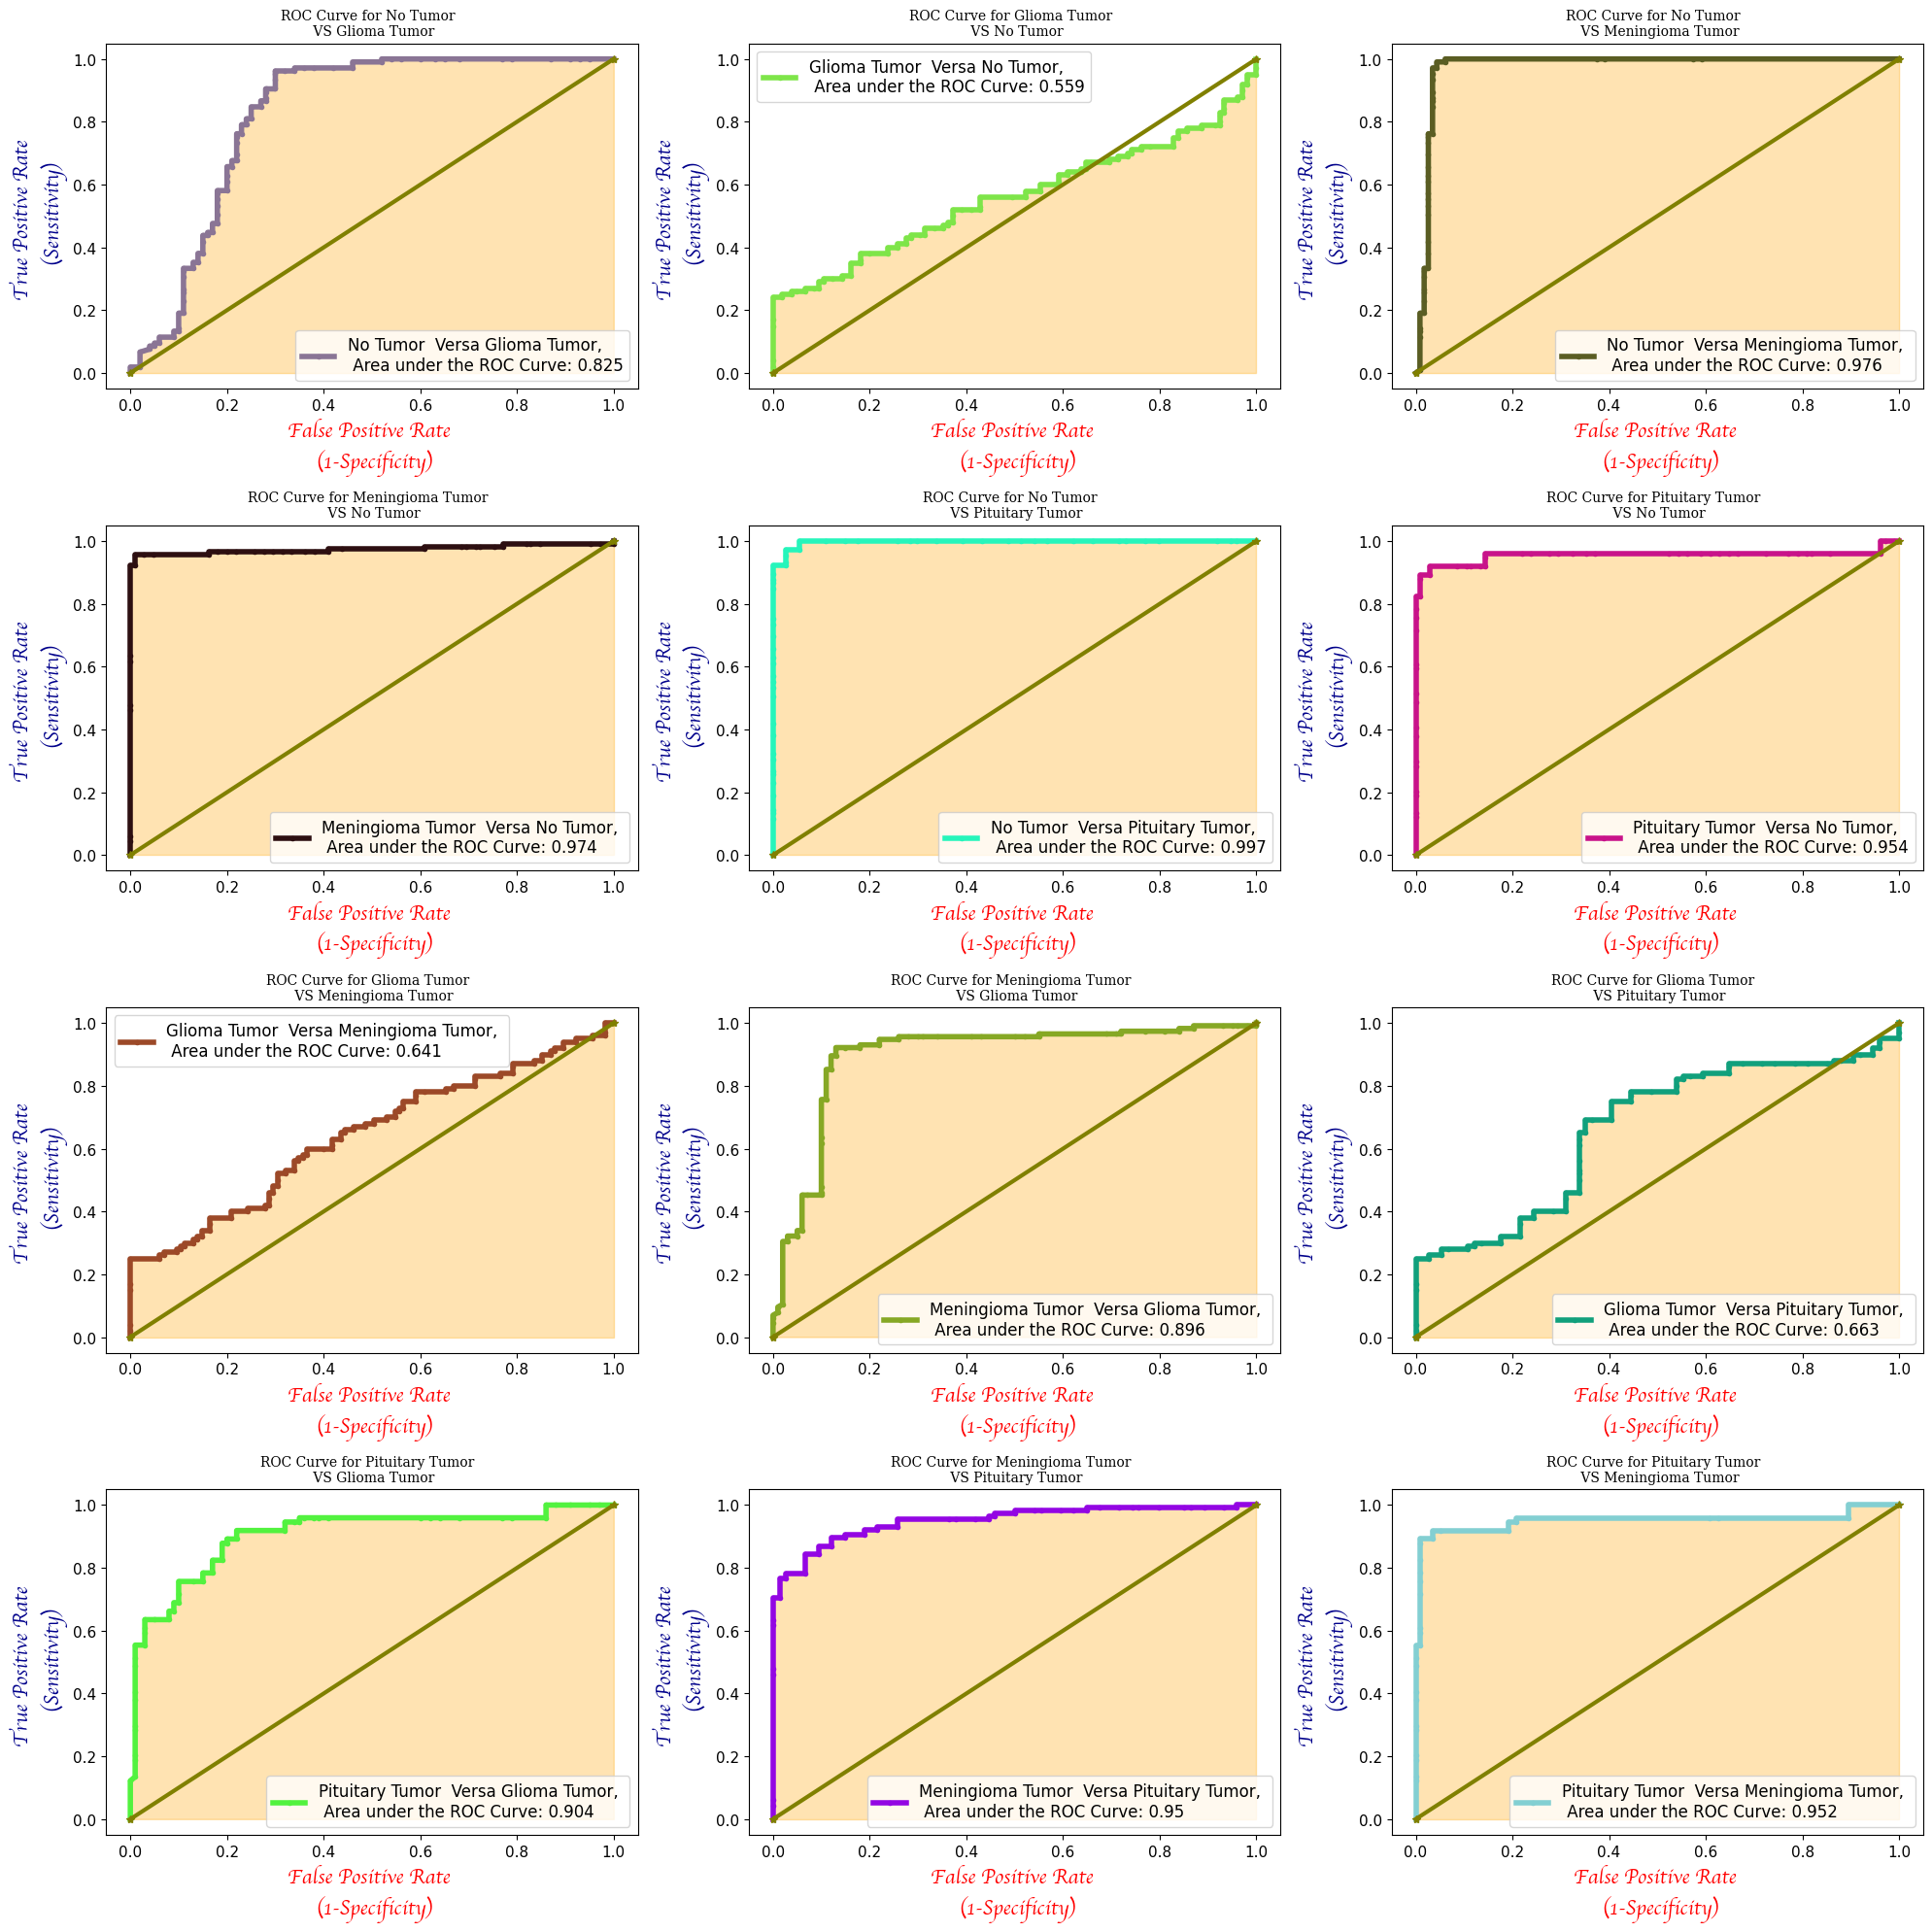

In [13]:
def One_VS_One_Plot_Roc_Curve(y_test, y_probabilities, n_classes):
    num_combinations = scipy.special.binom(int(n_classes), 2)*2
    number_col = int(np.floor(np.sqrt(num_combinations)))
    number_rows = int(np.ceil(np.sqrt(num_combinations)))
    plt.figure(figsize = (20, 20))
    all_combinations =[]

    auc_all = []
    #All combinations for n*(n-1) classifiers
    for first_iter in range(n_classes):
        for second_iter in range(first_iter+1, n_classes):
            all_combinations.append([first_iter, second_iter ])
            all_combinations.append([second_iter, first_iter ])
    
    for iter, compare in enumerate(all_combinations):
        class_compare1 = compare[0]
        class_compare2 = compare[1]
        df_auc = pd.DataFrame(y_probabilities, columns= [class_names[i] for i in range(n_classes)])
        df_auc['Class']= y_test
        
        df_auc = df_auc[(df_auc['Class']== class_compare1) | (df_auc['Class']== class_compare2)]

        df_auc['Class'] = [1 if iter == class_compare1 else 0 for iter in df_auc['Class']]
    
        fpr, tpr, _ = metrics.roc_curve(df_auc['Class'], df_auc.iloc[: , class_compare1])
        auc = np.round(metrics.auc(fpr, tpr), 3)
        auc_all.append(auc)

        ax = plt.subplot(number_rows , number_col ,iter+1 )
        #col = tuple(np.random.choice(range(0, 2), size=3))
        rgb = (random.random(), random.random(), random.random())
        ax.plot(fpr, tpr, '.-' ,color=rgb, lw=4, 
                label= f'{class_names[class_compare1]}  Versa {class_names[class_compare2]}, \n Area under the ROC Curve: {auc}' )
        ax.fill_between(fpr, tpr, color='orange', alpha=0.3)
        ax.set_xlabel('False Positive Rate \n (1-Specificity)',fontname="cursive", fontsize=15)
        ax.plot([0, 1], [0, 1], '*-', lw=3, c='olive')
        ax.set_ylabel('True Positive Rate \n (Sensitivity)', fontname= 'cursive', fontsize=15)
        ax.set_title(f'ROC Curve for {class_names[class_compare1]}  \n VS {class_names[class_compare2]}',
                     fontname="serif", fontsize=10)
        ax.legend(fontsize=12)
        ax.xaxis.label.set_color('red')
        ax.yaxis.label.set_color('darkblue') 
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        #plt.xa 
        
    plt.tight_layout()  

    print(f'\n \n The Macro Averaging of the Area under the ROC Curve is: {np.round(np.sum(auc_all)/len(auc_all), 3)} ')  

One_VS_One_Plot_Roc_Curve(Y_test_MRI, y_pred_probabilities,  4)






